In [1]:
"""
In this nb, we are forecasting Time-Series with a Recurrent Neural Network(RNN) Model. First, we use Sequence 
to Vector model in which the last Recurrent Layer has only single output. This approach is much slower and we 
directly predict forecast for 30th day.

Second, we use Sequence to Sequence Model in which last Recurrent layer has output at every time-step. Here,
we forecast for the next day given current day's value. This approach is much faster and better because while
back-propagating, the weights and biases are much better adjusted.
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 
# series = baseline + trend(time,0.1)

# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Creating Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline

# Creating White Noise
noise_level = 5
noise = white_noise(time,noise_level)

# Creating seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

# Creating Training and Validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [2]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Epoch 1/100
8/8 [==============================] - 4s 478ms/step - loss: 49.3687 - mae: 50.5252
Epoch 2/100
8/8 [==============================] - 1s 114ms/step - loss: 27.2750 - mae: 27.7552
Epoch 3/100
8/8 [==============================] - 1s 119ms/step - loss: 25.7940 - mae: 26.0130
Epoch 4/100
8/8 [==============================] - 1s 146ms/step - loss: 23.7815 - mae: 24.2639
Epoch 5/100
8/8 [==============================] - 1s 101ms/step - loss: 21.8357 - mae: 22.2915
Epoch 6/100
8/8 [==============================] - 1s 76ms/step - loss: 20.7489 - mae: 21.2822
Epoch 7/100
8/8 [==============================] - 0s 61ms/step - loss: 19.9897 - mae: 20.4492
Epoch 8/100
8/8 [==============================] - 1s 63ms/step - loss: 18.9479 - mae: 19.5434
Epoch 9/100
8/8 [==============================] - 1s 77ms/step - loss: 18.2244 - mae: 18.8338
Epoch 10/100
8/8 [==============================] - 0s 58ms/step - loss: 17.6343 - mae: 18.2066
Epoch 11/100
8/8 [==========================

8/8 [==============================] - 0s 62ms/step - loss: 5264.1626 - mae: 5285.9541
Epoch 86/100
8/8 [==============================] - 1s 67ms/step - loss: 6874.3572 - mae: 6665.6602
Epoch 87/100
8/8 [==============================] - 0s 58ms/step - loss: 8043.8601 - mae: 7909.0996
Epoch 88/100
8/8 [==============================] - 1s 72ms/step - loss: 7599.0728 - mae: 7936.4385
Epoch 89/100
8/8 [==============================] - 0s 61ms/step - loss: 10189.3003 - mae: 10068.3848
Epoch 90/100
8/8 [==============================] - 1s 63ms/step - loss: 10647.8807 - mae: 10276.4932
Epoch 91/100
8/8 [==============================] - 0s 56ms/step - loss: 5967.9650 - mae: 7032.1279
Epoch 92/100
8/8 [==============================] - 0s 56ms/step - loss: 27188.8400 - mae: 25513.6074
Epoch 93/100
8/8 [==============================] - 0s 56ms/step - loss: 14896.8217 - mae: 14967.9570
Epoch 94/100
8/8 [==============================] - 0s 57ms/step - loss: 9329.4448 - mae: 10070.0361
Epoc

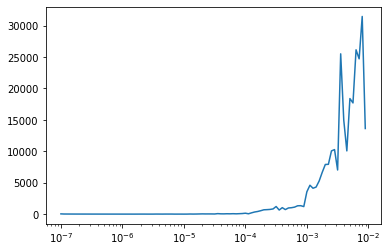

In [3]:
# --------------------Sequence To Vector Model---------------------------#

# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size, batch_size=128)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
model = tf.keras.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),
                       input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

plt.semilogx(history.history['lr'],history.history['loss'])

In [4]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = window_dataset(x_train,window_size, batch_size=128)
valid_set = window_dataset(x_valid,window_size, batch_size=128)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
model = tf.keras.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),
                       input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

# Train the model
history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper,model_checkpoint])


Epoch 1/100
8/8 [==============================] - 4s 469ms/step - loss: 69.2390 - mae: 69.2516 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 1s 88ms/step - loss: 47.8278 - mae: 47.5644 - val_loss: 43.5315 - val_mae: 44.4453
Epoch 3/100
8/8 [==============================] - 1s 84ms/step - loss: 32.3301 - mae: 32.9776 - val_loss: 36.7344 - val_mae: 37.1666
Epoch 4/100
8/8 [==============================] - 1s 79ms/step - loss: 30.3629 - mae: 28.5696 - val_loss: 16.0386 - val_mae: 17.0914
Epoch 5/100
8/8 [==============================] - 1s 88ms/step - loss: 21.0822 - mae: 21.8728 - val_loss: 11.3949 - val_mae: 11.7585
Epoch 6/100
8/8 [==============================] - 1s 75ms/step - loss: 17.4924 - mae: 17.2862 - val_loss: 11.8306 - val_mae: 12.2355
Epoch 7/100
8/8 [==============================] - 1s 88ms/step - loss: 14.3238 - mae: 14.8922 - val_loss: 8.1881 - val_mae: 8.6858
Epoch 8/100
8/8 [==============================] - 1s 81m

8/8 [==============================] - 1s 74ms/step - loss: 6.1099 - mae: 6.5946 - val_loss: 9.2806 - val_mae: 9.5752
Epoch 64/100
8/8 [==============================] - 1s 75ms/step - loss: 6.1688 - mae: 6.5785 - val_loss: 8.1637 - val_mae: 8.9338
Epoch 65/100
8/8 [==============================] - 1s 77ms/step - loss: 5.9849 - mae: 6.5472 - val_loss: 7.3598 - val_mae: 7.7040
Epoch 66/100
8/8 [==============================] - 1s 97ms/step - loss: 6.0918 - mae: 6.7208 - val_loss: 7.5409 - val_mae: 8.1328
Epoch 67/100
8/8 [==============================] - 1s 74ms/step - loss: 6.0351 - mae: 6.5791 - val_loss: 9.2744 - val_mae: 9.7212
Epoch 68/100
8/8 [==============================] - 1s 84ms/step - loss: 5.9808 - mae: 6.5616 - val_loss: 7.3030 - val_mae: 7.5797
Epoch 69/100
8/8 [==============================] - 1s 83ms/step - loss: 6.0592 - mae: 6.4093 - val_loss: 8.1421 - val_mae: 8.7317
Epoch 70/100
8/8 [==============================] - 1s 85ms/step - loss: 6.1081 - mae: 6.4252 - 

In [5]:
model = keras.models.load_model("my_checkpoint.h5")

In [6]:
rnn_forecast = model_forecast(model,
                             series[split_time-window_size:-1],
                             window_size)[:,0]

6.7775607

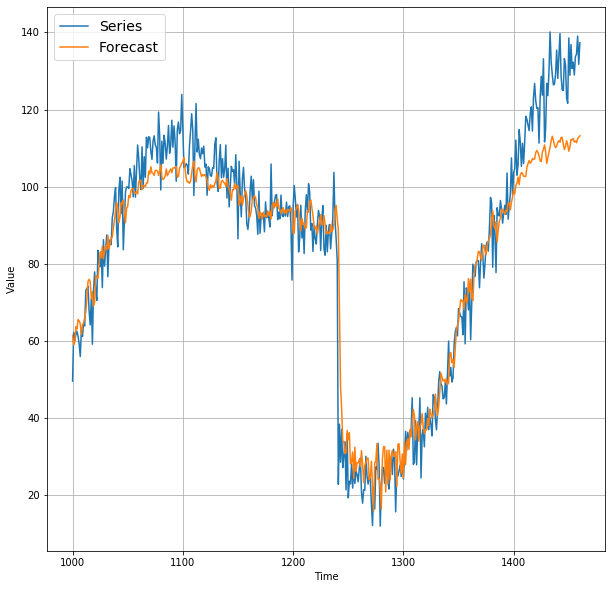

In [7]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")

keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

In [8]:
# Function to create dataset in proper format for Seq2Seq Model
def seq2seq_window_dataset(series,window_size=30,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1],x[1:]))
    return ds.batch(batch_size).prefetch(1)

Epoch 1/100
8/8 [==============================] - 3s 393ms/step - loss: 51.7239 - mae: 52.8090
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 30.1766 - mae: 30.9173
Epoch 3/100
8/8 [==============================] - 1s 63ms/step - loss: 29.5827 - mae: 29.8711
Epoch 4/100
8/8 [==============================] - 0s 60ms/step - loss: 27.3031 - mae: 27.5418
Epoch 5/100
8/8 [==============================] - 1s 64ms/step - loss: 25.4013 - mae: 25.9605
Epoch 6/100
8/8 [==============================] - 0s 61ms/step - loss: 24.4806 - mae: 24.8700
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 23.7021 - mae: 24.0135
Epoch 8/100
8/8 [==============================] - 1s 66ms/step - loss: 22.7937 - mae: 23.2228
Epoch 9/100
8/8 [==============================] - 0s 59ms/step - loss: 22.0655 - mae: 22.4841
Epoch 10/100
8/8 [==============================] - 0s 58ms/step - loss: 21.1590 - mae: 21.7318
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 61ms/step - loss: 4418.3921 - mae: 4272.3452
Epoch 86/100
8/8 [==============================] - 0s 58ms/step - loss: 3062.2607 - mae: 3209.9780
Epoch 87/100
8/8 [==============================] - 0s 60ms/step - loss: 4167.2839 - mae: 4037.0479
Epoch 88/100
8/8 [==============================] - 1s 65ms/step - loss: 4011.8073 - mae: 4171.8281
Epoch 89/100
8/8 [==============================] - 1s 67ms/step - loss: 4388.1967 - mae: 4647.2583
Epoch 90/100
8/8 [==============================] - 1s 66ms/step - loss: 5035.8604 - mae: 5330.7988
Epoch 91/100
8/8 [==============================] - 0s 62ms/step - loss: 5873.7852 - mae: 6081.7368
Epoch 92/100
8/8 [==============================] - 0s 59ms/step - loss: 6847.3247 - mae: 6947.2534
Epoch 93/100
8/8 [==============================] - 0s 58ms/step - loss: 7805.2062 - mae: 7834.9590
Epoch 94/100
8/8 [==============================] - 0s 59ms/step - loss: 8834.1931 - mae: 8938.7568
Epoch 95/100


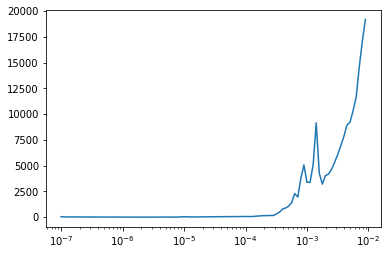

In [9]:
# --------------------Sequence To Sequence Model---------------------------#

# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size, batch_size=128)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
model = tf.keras.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

plt.semilogx(history.history['lr'],history.history['loss'])

In [10]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid,window_size, batch_size=128)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
model = tf.keras.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,input_shape = [None,1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

# Train the model
history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper,model_checkpoint])

Epoch 1/100
8/8 [==============================] - 4s 459ms/step - loss: 66.2718 - mae: 66.5324 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 1s 74ms/step - loss: 49.8525 - mae: 48.1943 - val_loss: 51.5092 - val_mae: 52.0252
Epoch 3/100
8/8 [==============================] - 1s 78ms/step - loss: 35.4090 - mae: 36.4711 - val_loss: 30.3074 - val_mae: 30.8921
Epoch 4/100
8/8 [==============================] - 1s 78ms/step - loss: 30.0435 - mae: 29.4599 - val_loss: 17.4125 - val_mae: 18.1929
Epoch 5/100
8/8 [==============================] - 1s 77ms/step - loss: 22.9823 - mae: 23.4031 - val_loss: 13.4937 - val_mae: 13.9092
Epoch 6/100
8/8 [==============================] - 1s 80ms/step - loss: 19.3972 - mae: 19.9590 - val_loss: 10.6023 - val_mae: 10.9736
Epoch 7/100
8/8 [==============================] - 1s 80ms/step - loss: 18.0641 - mae: 17.7793 - val_loss: 9.8536 - val_mae: 10.3352
Epoch 8/100
8/8 [==============================] - 1s 75

8/8 [==============================] - 1s 74ms/step - loss: 6.8922 - mae: 7.4516 - val_loss: 6.0188 - val_mae: 6.4647
Epoch 64/100
8/8 [==============================] - 1s 75ms/step - loss: 6.8794 - mae: 7.4218 - val_loss: 6.0272 - val_mae: 6.5119
Epoch 65/100
8/8 [==============================] - 1s 81ms/step - loss: 6.8958 - mae: 7.3902 - val_loss: 5.5702 - val_mae: 6.0363
Epoch 66/100
8/8 [==============================] - 1s 80ms/step - loss: 6.9435 - mae: 7.3585 - val_loss: 5.8790 - val_mae: 6.4019
Epoch 67/100
8/8 [==============================] - 1s 77ms/step - loss: 6.7361 - mae: 7.3211 - val_loss: 5.6832 - val_mae: 6.1787
Epoch 68/100
8/8 [==============================] - 1s 105ms/step - loss: 6.7768 - mae: 7.2858 - val_loss: 5.8056 - val_mae: 6.2762
Epoch 69/100
8/8 [==============================] - 1s 75ms/step - loss: 6.7365 - mae: 7.2557 - val_loss: 5.5716 - val_mae: 6.0377
Epoch 70/100
8/8 [==============================] - 1s 79ms/step - loss: 6.8904 - mae: 7.2274 -

5.0414724

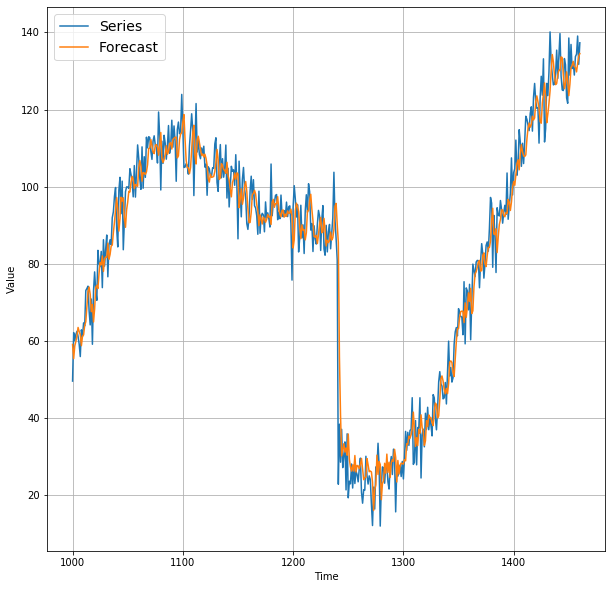

In [11]:
model = keras.models.load_model("my_checkpoint.h5")
# Model expects 3-d data while we have series(2-d) data
rnn_forecast = model_forecast(model, series[...,np.newaxis], window_size)[split_time-window_size:-1,-1,0]
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()
# MAE of 5.04